<a href="https://colab.research.google.com/github/danoAasland/PrescriptionChecker/blob/master/RxMedCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Installs to local env
!pip install kmodes

In [0]:
#Packages
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from google.colab import files
import io

#set graphs to plot within env and supress any warnings
%matplotlib inline
warnings.filterwarnings('ignore')

#Aesthetics
#set font type
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#set style of graphs
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(12, 6)})

**IMPORT DATA**


In [0]:
#Save patient encounters data to dataframe
url = 'https://raw.githubusercontent.com/danoAasland/PrescriptionChecker/master/EMR_Data/encounters.csv'
encounterDF = pd.read_csv(url)

In [0]:
#Save patient medications data to dataframe
url = 'https://raw.githubusercontent.com/danoAasland/PrescriptionChecker/master/EMR_Data/medications.csv'
medDF = pd.read_csv(url)

In [0]:
#Save patient demographics data to dataframe
url = 'https://raw.githubusercontent.com/danoAasland/PrescriptionChecker/master/EMR_Data/patients.csv'
patientsDF = pd.read_csv(url)

In [0]:
#Save patient procedures data to dataframe
url = 'https://raw.githubusercontent.com/danoAasland/PrescriptionChecker/master/EMR_Data/procedures.csv'
procedureDF = pd.read_csv(url)

In [0]:
#Save patient allergies data to dataframe
url = 'https://raw.githubusercontent.com/danoAasland/PrescriptionChecker/master/EMR_Data/allergies.csv'
allergiesDF = pd.read_csv(url)

**DATA INSPECTION/EVALUATION**


In [10]:
#encounters data
encounterDF.shape

(46868, 14)

In [0]:
#uncomment to run
#encounterDF.info()

In [0]:
#uncomment to run
#encounterDF.describe(include='all')

In [0]:
#uncomment to run
#encounterDF.head(1)

In [0]:
#convert object to date time format
encounterDF['START'] = pd.to_datetime(encounterDF.START, infer_datetime_format=True)

In [0]:
#convert datetime to date only for encounter date
encounterDF['START'] = pd.to_datetime(encounterDF['START']).dt.date

In [16]:
#medications data
medDF.shape

(14102, 13)

In [0]:
#uncomment to run
#medDF.info()

In [0]:
#uncomment to run
#medDF.describe(include='all')

In [0]:
#uncomment to run
#medDF.head()

In [0]:
#convert start date column to date format
medDF['START'] = pd.to_datetime(medDF.START, infer_datetime_format=True)

In [22]:
#patients demogrpahics data
patientsDF.shape

(1180, 25)

In [0]:
#uncomment to run
#patientsDF.info()

In [0]:
#uncomment to run
#patientsDF.describe(include='all')

In [0]:
#uncomment to run
#patientsDF.head(1)

In [0]:
#convert birthdate column to date format
patientsDF['BIRTHDATE'] = pd.to_datetime(patientsDF.BIRTHDATE, infer_datetime_format=True)

In [27]:
#patient procedures data
procedureDF.shape

(36451, 8)

In [0]:
#uncomment to run
#procedureDF.info()

In [0]:
#uncomment to run
#procedureDF.describe(include='all')

In [0]:
#uncomment to run
#procedureDF.head()

In [0]:
#convert date column to date format
procedureDF['DATE'] = pd.to_datetime(procedureDF.DATE, infer_datetime_format=True)

In [32]:
#patients allergies data
allergiesDF.shape

(567, 6)

In [0]:
#uncomment to run
#allergiesDF.info()

In [0]:
#uncomment to run
#allergiesDF.describe(include='all')

In [0]:
#uncomment to run
#allergiesDF.head()

In [0]:
#convert start date column to date format
allergiesDF['START'] = pd.to_datetime(allergiesDF.START, infer_datetime_format=True)

In [0]:
#dict allergy [type] by patient
allergyByPatient = dict(zip(allergiesDF.PATIENT, allergiesDF.DESCRIPTION))

**DATA MUNGING**


In [0]:
#create copy of DF to be modified later
aggEmrDF = medDF.copy()

In [0]:
#uncomment to run
#aggEmrDF.head()

In [0]:
#maps allergies to patient
aggEmrDF['ALLERGY'] = aggEmrDF['PATIENT'].map(allergyByPatient)

In [0]:
#if no allergy present replace NaN with NKA
aggEmrDF['ALLERGY'] = aggEmrDF.ALLERGY.fillna(value='NKA')

In [0]:
#remove all non-useful columns
aggEmrDF = aggEmrDF.drop(columns=['STOP', 'PAYER', 'CODE', 'BASE_COST', 'PAYER_COVERAGE', 'TOTALCOST', 'REASONCODE', 'REASONDESCRIPTION'])

In [0]:
examReason = dict(zip(encounterDF.Id, encounterDF.REASONDESCRIPTION))

In [0]:
examType = dict(zip(encounterDF.Id, encounterDF.DESCRIPTION))

In [0]:
aggEmrDF['EXAM_REASON'] = aggEmrDF['ENCOUNTER'].map(examReason)

In [0]:
aggEmrDF['EXAM_TYPE'] = aggEmrDF['ENCOUNTER'].map(examType)

In [0]:
#if no known exam reason replace NaN with Unknown
aggEmrDF['EXAM_REASON'] = aggEmrDF.EXAM_REASON.fillna(value='Unknown')

In [0]:
patientGender = dict(zip(patientsDF.Id, patientsDF.GENDER))

In [0]:
now = pd.to_datetime('now')
#now
patientsDF['AGE'] = (now - patientsDF['BIRTHDATE']).astype('<m8[Y]') 

In [0]:
patientAge = dict(zip(patientsDF.Id, patientsDF.AGE))

In [0]:
aggEmrDF['AGE'] = aggEmrDF['PATIENT'].map(patientAge)

In [0]:
aggEmrDF['GENDER'] = aggEmrDF['PATIENT'].map(patientGender)

In [0]:
aggEmrDF['AGE'] = aggEmrDF['AGE'].astype(int)

In [54]:
aggEmrDF.head()

,START,PATIENT,ENCOUNTER,DESCRIPTION,DISPENSES,ALLERGY,EXAM_REASON,EXAM_TYPE,AGE,GENDER
0,1995-11-16,3603cd65-53a3-424b-bc82-76204326510d,f5ddf34a-85c6-4f03-9c82-34e25fde945d,Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...,290,NKA,Unknown,Hypertension follow-up encounter,42,M
1,2010-02-12,3603cd65-53a3-424b-bc82-76204326510d,ae97dfe0-c619-44c1-a687-f215d7fac984,Acetaminophen 325 MG Oral Tablet,1,NKA,Acute bronchitis (disorder),Encounter for symptom,42,M
2,2012-07-08,3603cd65-53a3-424b-bc82-76204326510d,7616a2fe-0ddc-44b4-84ae-1bca998b1c45,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,1,NKA,Viral sinusitis (disorder),Encounter for symptom,42,M
3,2011-03-26,21dd496c-2fec-4c9c-a0fe-c11ad5b2cdea,86d22444-38b4-4481-bc31-8a509a56118b,Cefuroxime 250 MG Oral Tablet,1,NKA,Otitis media,Encounter for symptom,13,M
4,2011-03-26,21dd496c-2fec-4c9c-a0fe-c11ad5b2cdea,86d22444-38b4-4481-bc31-8a509a56118b,Ibuprofen 100 MG Oral Tablet,1,NKA,Otitis media,Encounter for symptom,13,M


In [0]:
trainTestRawDF = aggEmrDF[['DESCRIPTION', 'DISPENSES', 'EXAM_REASON', 'EXAM_TYPE', 'AGE', 'GENDER']]

In [56]:
trainTestRawDF.DESCRIPTION.value_counts()

1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]    4133
Simvistatin 10 MG                                   2306
Cisplatin 50 MG Injection                            880
PACLitaxel 100 MG Injection                          820
Acetaminophen 325 MG Oral Tablet                     622
                                                    ... 
10 ML Pamidronate Disodium 3 MG/ML Injection           1
ribociclib 200 MG Oral Tablet                          1
Alfentanil                                             1
letrozole 2.5 MG Oral Tablet                           1
anastrozole 1 MG Oral Tablet                           1
Name: DESCRIPTION, Length: 151, dtype: int64

In [57]:
trainTestRawDF.EXAM_REASON.value_counts()

Unknown                                                                  9102
Hyperlipidemia                                                           2308
Acute bronchitis (disorder)                                               555
Otitis media                                                              342
Viral sinusitis (disorder)                                                242
Streptococcal sore throat (disorder)                                      180
Chronic congestive heart failure (disorder)                               171
Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)     120
Anemia (disorder)                                                         103
Childhood asthma                                                          102
Chronic pain                                                               80
Neoplasm of prostate                                                       76
Chronic intractable migraine without aura                       

In [58]:
trainTestRawDF.EXAM_TYPE.value_counts()

Encounter for problem (procedure)                              4134
Encounter for problem                                          2597
Follow-up encounter                                            2312
Encounter for symptom                                          1556
Consultation for treatment                                     1175
Emergency room admission (procedure)                            763
General examination of patient (procedure)                      663
Encounter Inpatient                                             227
Hypertension follow-up encounter                                184
Encounter for check up (procedure)                               84
Emergency Room Admission                                         73
Inpatient stay (finding)                                         55
Well child visit (procedure)                                     43
Stroke                                                           39
Myocardial Infarction                           

In [59]:
trainTestRawDF.describe()

,DISPENSES,AGE
count,14102.000000,14102.000000
mean,40.657212,74.092611
std,314.287178,30.204956
min,1.000000,0.000000
25%,1.000000,53.000000
50%,1.000000,83.000000
75%,12.000000,102.000000
max,20318.000000,108.000000


In [60]:
trainTestRawDF.DISPENSES.sort_values(ascending= False)

12275    20318
9216     19874
8707     12964
9948     10770
8596     10055
         ...  
6472         1
6471         1
6470         1
6469         1
7050         1
Name: DISPENSES, Length: 14102, dtype: int64

In [0]:
trainTestValueCount = trainTestRawDF.DISPENSES.value_counts()

In [62]:
len(trainTestValueCount)

597

In [63]:
trainTestValueCount[-20:]

869      1
347      1
307      1
650      1
294      1
12964    1
682      1
730      1
738      1
746      1
842      1
286      1
283      1
230      1
107      1
166      1
126      1
94       1
203      1
20318    1
Name: DISPENSES, dtype: int64

In [0]:
#setting cutoff param dispense counts ( 1 Pill Q 4 Hours X 90 Day Supply = 540 )
trainTestRawDF = trainTestRawDF[trainTestRawDF.DISPENSES <= 540]

In [65]:
trainTestRawDF.DISPENSES.sort_values(ascending= False)

4245     539
4246     539
13930    539
10545    538
10955    538
        ... 
6512       1
6511       1
6510       1
6509       1
7049       1
Name: DISPENSES, Length: 13880, dtype: int64

In [66]:
trainTestRawDF.head()

,DESCRIPTION,DISPENSES,EXAM_REASON,EXAM_TYPE,AGE,GENDER
0,Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...,290,Unknown,Hypertension follow-up encounter,42,M
1,Acetaminophen 325 MG Oral Tablet,1,Acute bronchitis (disorder),Encounter for symptom,42,M
2,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,1,Viral sinusitis (disorder),Encounter for symptom,42,M
3,Cefuroxime 250 MG Oral Tablet,1,Otitis media,Encounter for symptom,13,M
4,Ibuprofen 100 MG Oral Tablet,1,Otitis media,Encounter for symptom,13,M


In [67]:
len(trainTestRawDF.DESCRIPTION.unique())

150

In [68]:
len(trainTestRawDF.EXAM_REASON.unique())

50

In [69]:
len(trainTestRawDF.EXAM_TYPE.unique())

29

In [72]:
trainTestRawDF.tail(3)

,DESCRIPTION,DISPENSES,EXAM_REASON,EXAM_TYPE,AGE,GENDER
14099,Simvistatin 10 MG,12,Hyperlipidemia,Follow-up encounter,68,M
14100,Simvistatin 10 MG,12,Hyperlipidemia,Follow-up encounter,68,M
14101,Simvistatin 10 MG,12,Hyperlipidemia,Follow-up encounter,68,M


**EVALUATING CLUSTER METHODS (LOCAL OUTLIER AND KMEANS)**


In [0]:
lof = LocalOutlierFactor(n_neighbors= 50, novelty=True)

In [81]:
lof.fit(medTransDF)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=50, novelty=True, p=2)

In [82]:
lof.negative_outlier_factor_

array([-0.98782895, -1.00186907, -1.00767533, ..., -1.        ,
       -1.        , -1.        ])

In [100]:
len(lof.negative_outlier_factor_)

13880

In [0]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import LocalOutlierFactor

In [0]:
clusterTrainDF = trainTestRawDF.copy()

In [0]:
clusterTrainDF['LOF'] = lof.negative_outlier_factor_

In [107]:
clusterTrainDF.head()

,DESCRIPTION,DISPENSES,EXAM_REASON,EXAM_TYPE,AGE,GENDER,LOF,CLUSTERS
0,Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...,290,Unknown,Hypertension follow-up encounter,42,M,-0.987829,3
1,Acetaminophen 325 MG Oral Tablet,1,Acute bronchitis (disorder),Encounter for symptom,42,M,-1.001869,1
2,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,1,Viral sinusitis (disorder),Encounter for symptom,42,M,-1.007675,1
3,Cefuroxime 250 MG Oral Tablet,1,Otitis media,Encounter for symptom,13,M,-0.997242,0
4,Ibuprofen 100 MG Oral Tablet,1,Otitis media,Encounter for symptom,13,M,-1.001199,0


In [0]:
clusters = KPrototypes().fit_predict(trainTestRawDF, categorical=[0, 2, 3, 5])

In [105]:
clusters

array([3, 1, 1, ..., 5, 5, 5], dtype=uint16)

In [0]:
clusterTrainDF['CLUSTERS'] = clusters

In [0]:
subTrain3cols = clusterTrainDF[['DESCRIPTION', 'DISPENSES',	'EXAM_REASON']]

In [108]:
subTrain3cols.head()

,DESCRIPTION,DISPENSES,EXAM_REASON
0,Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...,290,Unknown
1,Acetaminophen 325 MG Oral Tablet,1,Acute bronchitis (disorder)
2,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,1,Viral sinusitis (disorder)
3,Cefuroxime 250 MG Oral Tablet,1,Otitis media
4,Ibuprofen 100 MG Oral Tablet,1,Otitis media


In [109]:
clusterTrainDF.groupby(['CLUSTERS','EXAM_REASON']).count()

DESCRIPTION  ...  LOF
CLUSTERS EXAM_REASON                                                      ...     
0        Acute bacterial sinusitis (disorder)                          5  ...    5
         Acute bronchitis (disorder)                                 210  ...  210
         Acute viral pharyngitis (disorder)                            9  ...    9
         Anemia (disorder)                                             4  ...    4
         Atopic dermatitis                                            12  ...   12
...                                                                  ...  ...  ...
7        Perennial allergic rhinitis with seasonal varia...            1  ...    1
         Posttraumatic stress disorder                                 1  ...    1
         Rupture of patellar tendon                                    1  ...    1
         Seizure disorder                                              1  ...    1
         Unknown                                                     289  ...  289

[186 rows x 6 columns]

In [111]:
subTrain3cols.groupby(['EXAM_REASON','DESCRIPTION']).count()

DISPENSES
EXAM_REASON                DESCRIPTION                                                  
Acute Cholecystitis        1 ML Morphine Sulfate 5 MG/ML Injection                     4
                           100 ML Propofol 10 MG/ML Injection                          4
                           2 ML Ondansetron 2 MG/ML Injection                          8
                           Acetaminophen 325 MG / HYDROcodone Bitartrate 7...          2
                           Acetaminophen 325 MG / oxyCODONE Hydrochloride ...          1
...                                                                                  ...
Unknown                    palbociclib 100 MG Oral Capsule                             3
                           predniSONE 5 MG Oral Tablet                                31
                           ribociclib 200 MG Oral Tablet                               1
Viral sinusitis (disorder) 60 ACTUAT Fluticasone propionate 0.25 MG/ACTUAT...          6
                           Amoxicillin 250 MG / Clavulanate 125 MG Oral Ta...        236

[231 rows x 1 columns]

**PROOF OF CONCEPT** - 
Demo using *Ear Infection* as diagnosis type

In [0]:
#Sub DF for Ear Infection e.g. Otitis media
omDF = clusterTrainDF.loc[clusterTrainDF['EXAM_REASON'] == 'Otitis media']

In [0]:
#synthetic data had very low variation in dispense amount, replaced with random values between 1 and 15
omDF['DISPENSES'] = np.random.randint(1,15, size=len(omDF['DISPENSES']))

In [158]:
#Dist. of data within otitis media
omDF.describe(include='all')

,DESCRIPTION,DISPENSES,EXAM_REASON,EXAM_TYPE,AGE,GENDER,LOF,CLUSTERS
count,342,342.000000,342,342,342.000000,342,3.420000e+02,342.000000
unique,11,NaN,1,1,NaN,2,NaN,NaN
top,Amoxicillin 250 MG Oral Capsule,NaN,Otitis media,Encounter for symptom,NaN,F,NaN,NaN
freq,104,NaN,342,342,NaN,178,NaN,NaN
mean,NaN,7.374269,NaN,NaN,17.526316,NaN,-1.422871e+09,0.426901
std,NaN,4.037251,NaN,NaN,22.884080,NaN,8.245731e+09,1.276534
min,NaN,1.000000,NaN,NaN,0.000000,NaN,-6.818227e+10,0.000000
25%,NaN,4.000000,NaN,NaN,6.000000,NaN,-1.034511e+00,0.000000
50%,NaN,7.000000,NaN,NaN,9.000000,NaN,-9.992017e-01,0.000000
75%,NaN,11.000000,NaN,NaN,15.000000,NaN,-9.862558e-01,0.000000


In [0]:
#assigning all meds used for the treatment of ear infections to list
omMedList = omDF.DESCRIPTION.unique()

In [156]:
#viewing all meds currently used to treat ear infections
print(omMedList)

['Cefuroxime 250 MG Oral Tablet' 'Ibuprofen 100 MG Oral Tablet'
 'Amoxicillin 250 MG Oral Capsule' 'Acetaminophen 160 MG Oral Tablet'
 'Acetaminophen 325 MG Oral Tablet' 'Amoxicillin 500 MG Oral Tablet'
 'Naproxen sodium 220 MG Oral Tablet' 'Ibuprofen 200 MG Oral Tablet'
 'Aspirin 81 MG Oral Tablet' 'Doxycycline Monohydrate 100 MG Oral Tablet'
 '12 HR Cefaclor 500 MG Extended Release Oral Tablet']


In [0]:
#create min and max for one standard dev that covers that majority of treatment
omMax = omDF.DISPENSES.mean() + omDF.DISPENSES.std()
omMin = omDF.DISPENSES.mean() - omDF.DISPENSES.std()

In [0]:
#Function to check medication to be prescribed against current standard of care
#Input for new data in this form: variableName = [med name, qty, diagnosis]

def medCheckOM(dxList, medList, rangeMin, rangeMax):
  newOrder = []
  newOrder.append(input("Enter medication name here: "))
  newOrder.append(int(input("Enter quantity to be dispensed: ")))
  newOrder.append(input("Patient's diagnosis/exam reason: "))
  rangeMin = int(rangeMin)
  rangeMax = int(rangeMax)
  if newOrder[0] in medList:
    if newOrder[1] < rangeMax and newOrder[1] > rangeMin:
      if newOrder[2] in dxList:
        print("Valid medication and dosage quantity for %s" % newOrder[2])
  elif newOrder[0] not in medList:
    print("Medication not normally prescribed for %s" % newOrder[2])
  elif newOrder[1] > rangeMax or newOrder[1] < rangeMin:
    print("Medication quantity for %s normally dispensed quantity is between %d and %d " % (newOrder[2], rangeMin, rangeMax))
  elif newOrder[2] not in dxList:
    print("Medication not normally prescribed for %s" % newOrder[2])

In [167]:
medCheckOM(omDF.EXAM_REASON.unique(), omMedList, omMin, omMax)

Enter medication name here: predniSONE 5 MG Oral Tablet
Enter quantity to be dispensed: 10
Patient's diagnosis/exam reason: Otitis media
Medication not normally prescribed for Otitis media


In [168]:
medCheckOM(omDF.EXAM_REASON.unique(), omMedList, omMin, omMax)

Enter medication name here: Amoxicillin 250 MG Oral Capsule
Enter quantity to be dispensed: 7
Patient's diagnosis/exam reason: Otitis media
Valid medication and dosage quantity for Otitis media


**DISTRIBUTIONS SPECIFIC TO EAR INFECTION DATA**

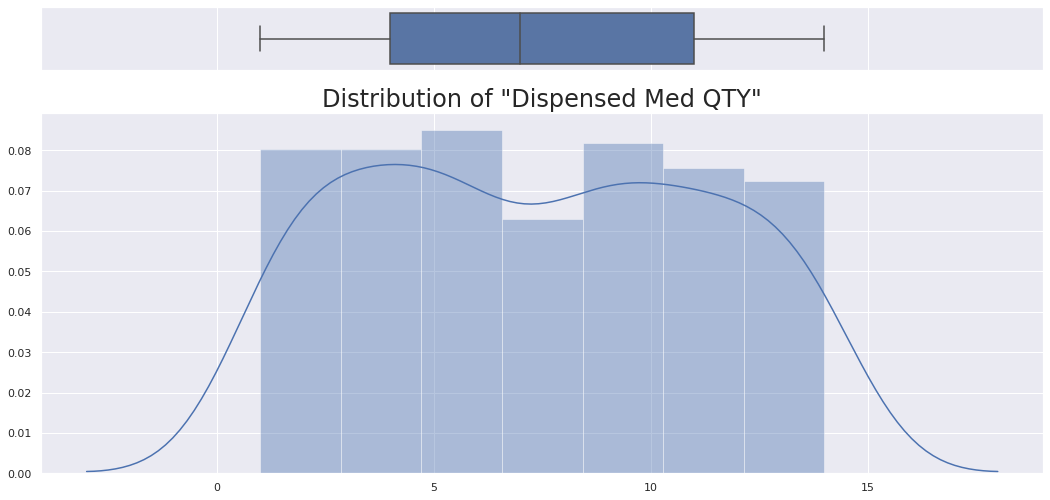

In [132]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(omDF.DISPENSES, ax=boxplot)
sns.distplot(omDF.DISPENSES, ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Dispensed Med QTY"', fontsize=24)
plt.xlabel('');

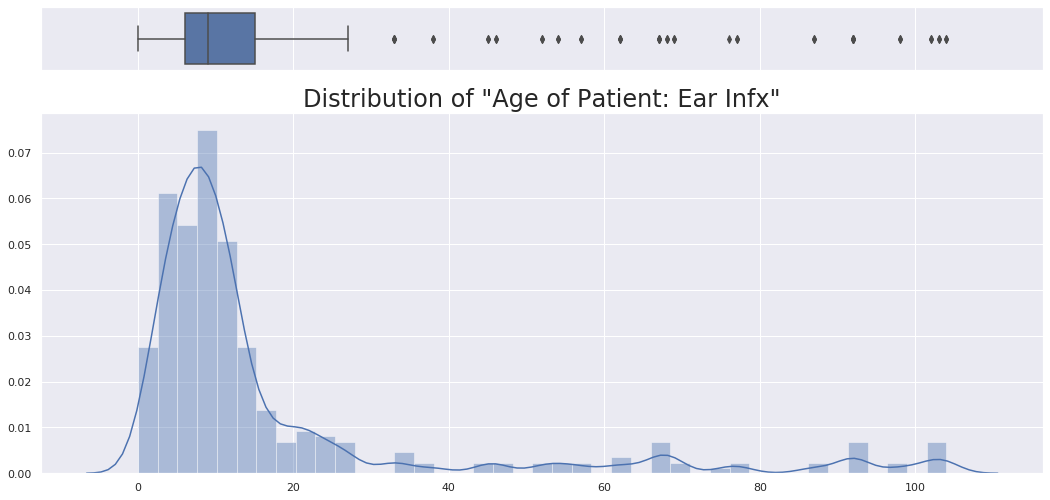

In [133]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(omDF.AGE, ax=boxplot)
sns.distplot(omDF.AGE, ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Age of Patient: Ear Infx"', fontsize=24)
plt.xlabel('');

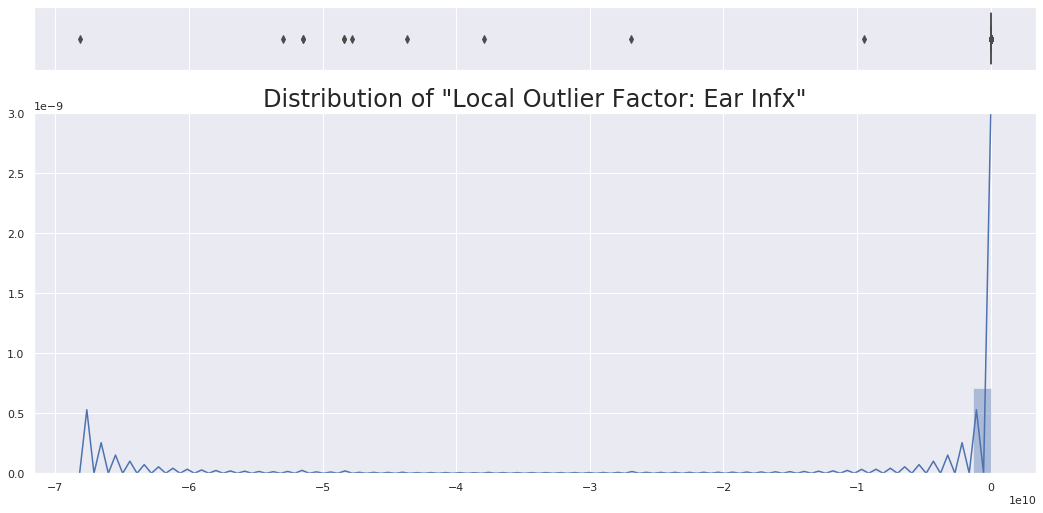

In [135]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(omDF.LOF, ax=boxplot)
sns.distplot(omDF.LOF, ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Local Outlier Factor: Ear Infx"', fontsize=24)
plt.xlabel('');

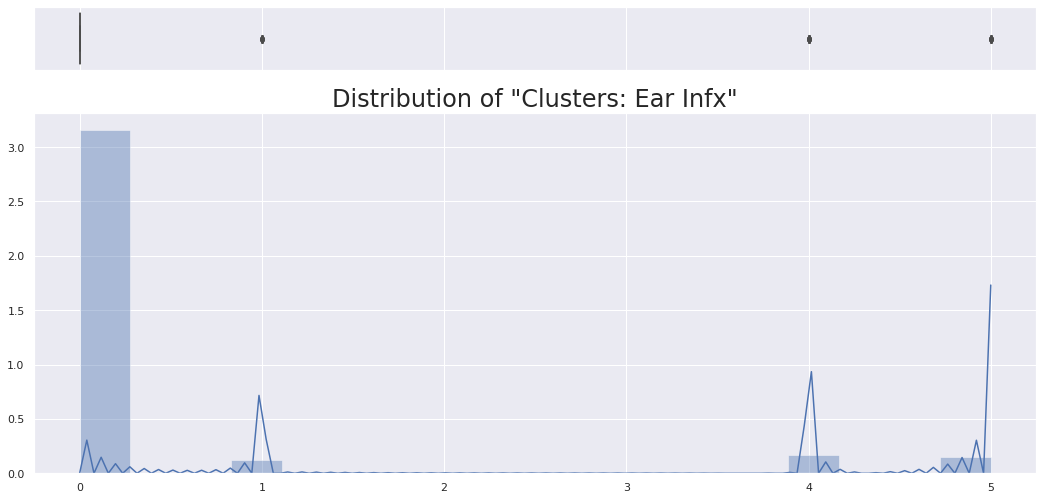

In [136]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(omDF.CLUSTERS, ax=boxplot)
sns.distplot(omDF.CLUSTERS, ax=histogram)
boxplot.set(xlabel='')
plt.title('Distribution of "Clusters: Ear Infx"', fontsize=24)
plt.xlabel('');